In [1]:
import os
from pathlib import Path
from eemeter import eemeter as em
from applied_data_science.bigquery.data import Meter_Data
from hourly_test_utils import *
#auto load the eemeter module
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt


In [2]:
dataset = 'mce_3_yr_precovid'
subsample = 5
has_solar = True

cache_dir = Path("/app/.recurve_cache/data").resolve()

if 'data' in globals():
    del data

data = Meter_Data(dataset, subsample, "hourly", solar=has_solar, cache_dir=cache_dir)
meta = data.df['meta']
subsample_df = data.df['meter']
ids = subsample_df.index.unique()

Loading: /app/.recurve_cache/data/MCE/MCE_3_yr_precovid_solar_meta_5.pkl
Done in 0.008 s
Loading: /app/.recurve_cache/data/MCE/MCE_3_yr_precovid_solar_hourly_meter_5.pkl
Done in 9.183 s


In [3]:
sid = ids[0]
lat = meta.loc[meta.index == sid].iloc[0]['station_latitude']
lon = meta.loc[meta.index == sid].iloc[0]['station_longitude']
sd = subsample_df.loc[sid].copy()
metadata = {'lat': lat, 'lon': lon, 'sid': sid}
config = {
    'window':1
}
data_loader = MCE_Data_Loader_Test(config)
sid, df_trains, df_tests = data_loader.get_all_cleaned_data(metadata, sd)


In [4]:
train_features = []
if 'temperature' not in train_features:
    train_features.append('temperature')
supplimental_data = False
# analytic_features = ['GHI', 'Temperature', 'DHI', 'DNI', 'Relative Humidity', 'Wind Speed', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type']
lagged_features = ['temperature'] # 'ghi'

output = ['start_local', 'temperature', 'ghi', 'clearsky_ghi', 'observed', 'new_model', 'month']
model_kwarg = {'alpha': 0.1, 'l1_ratio': 0.1, 'random_state': 1}
window = 1

settings = {'train_features': train_features, 'model_kwarg': model_kwarg, 'window': window,
        'lagged_features': lagged_features, 'output': output,  'supplimental_data': supplimental_data}

In [5]:
lr = em.HourlyModel(settings=settings)
k = 0
dft = df_trains[k]
lr.fit(dft)

# new_df = lr.predict(df_trains[k])
new_df = lr.predict(df_tests[k])


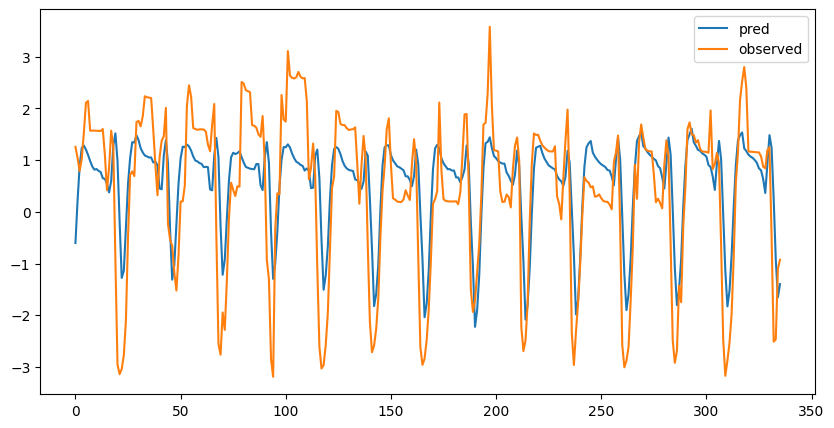

In [6]:
start = 24*80
window = 24*14
end = start + window
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(new_df['new_model'][start:end].values, label='pred')
plt.plot(new_df['observed'][start:end].values, label='observed')
plt.legend()
plt.show()